# Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import joblib

# Data Load

In [2]:
# Importing the pandas library and reading the CSV file 'Zephyr Data Emo with new categories-Copy1.csv'
# The 'engine' parameter is set to 'python' to handle non-default delimiter options.
# The 'delimiter' parameter is set to ';' to specify that the data in the CSV file is delimited by semicolons.

raw_core = pd.read_csv('Zephyr Data Emo with new categories-Copy1.csv', engine='python', delimiter=';')


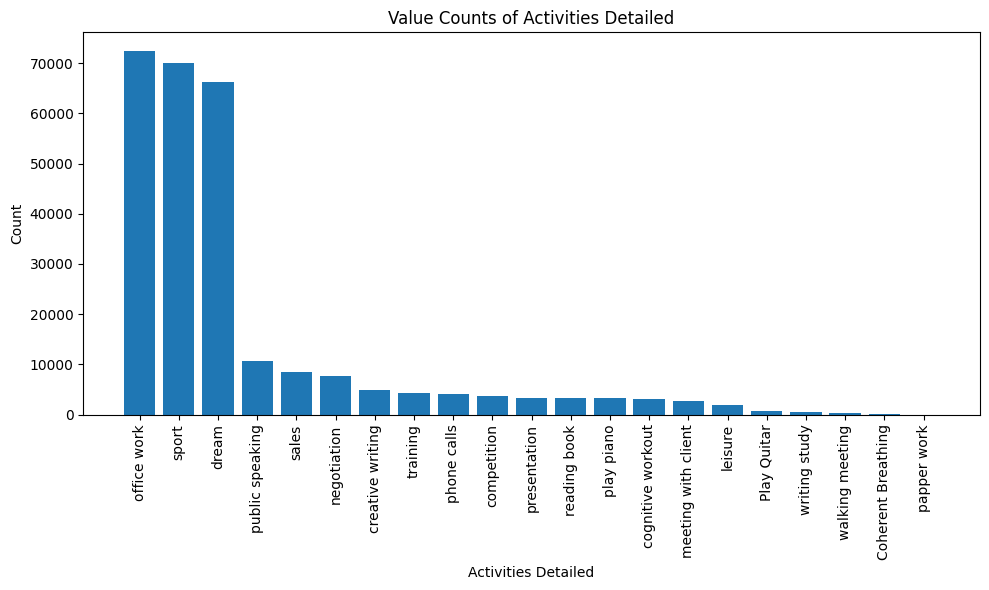

In [3]:
# Get the value counts for the 'Activities Detailed' column
value_counts = raw_core['Activities Detailed'].value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size if needed
plt.bar(value_counts.index, value_counts.values)

# Optional: Rotate the x-axis labels if they are too long
plt.xticks(rotation=90)

# Optional: Add labels and title
plt.xlabel('Activities Detailed')
plt.ylabel('Count')
plt.title('Value Counts of Activities Detailed')

# Show the plot
plt.tight_layout()  # Optional: To avoid cutoff of labels
plt.show()

In [4]:

# Creating a new DataFrame 'raw' by filtering out rows where the 'Activities Detailed' column is not equal to 'papper work'.
# This step is essentially excluding rows with the value 'papper work' in the 'Activities Detailed' column which has only 1 entry.
raw = raw_core[raw_core['Activities Detailed'] != 'papper work']


In [5]:
# Assuming 'raw' is a DataFrame containing the data.

# Extracting the 'Activities Detailed' column and assigning it to the 'y' variable.
y = raw[['Activities Detailed']]

# Creating a new DataFrame 'X' by dropping the 'Activities Detailed' and 'Activities' columns from the original DataFrame 'raw'.
# 'X' will contain the remaining features (columns) of the data.
X = raw.drop(columns=['Activities Detailed', 'Activities'])


# Data Prep

## Data Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

## Initial Data Cleaning

In [7]:
class DataCleanerTransformer:
    def __init__(self):
        # Define the columns that need to be converted to float
        self.float_columns = ['Activity', 'PeakAcceleration', 'ECGAmplitude', 'ECGNoise', 'CoreTemp',
                              'AvStepPeriod', 'AvForceDevRate', 'AvStepImpulse']
        
    def fit(self, data):
        # Nothing to fit in this case, so we return self.
        return self

    def transform(self, data):
        # Convert selected columns to float
        data[self.float_columns] = data[self.float_columns].apply(lambda x: x.str.replace(',', '.').astype(float))

        # Convert 'Time' column to pandas datetime format
        data['Time_New'] = pd.to_datetime(data['Time'], format="%d.%m.%Y %H:%M:%S")

        # Fill NaN values with 0
        data = data.fillna(0)
        
        return data

    def fit_transform(self, data):
        # Fit the transformer (in this case, there's nothing to fit)
        self.fit(data)

        # Transform the data using the transform method
        return self.transform(data)


# Example usage:
# Instantiate the DataCleanerTransformer class
data_cleaner = DataCleanerTransformer()

X_train_loaded = data_cleaner.fit_transform(X_train)

## Data Reduction

In [8]:
drop = [
        #The model overfits and remmember when what activities were done so they are removed
        'Year', 'Month', 'Weekday', 'Time', 'Time_New','Date','Hour',
    
        #We have few participants so the model is good at overfitting who did what
        'Name of the volunteer',
        
        #These are health KPIs of how the Holter machine works and aren't dependant on activity.
        'BRAmplitude','ECGAmplitude', 'HRConfidence',
        
        #These measure how the machine works and whether it detects noise. This is what we model.
        'ECGNoise','Jumps','JumpFlightTime'
    
        #Stress is mannualy inputted
#         ,'Controled stress',' stress', 'Before Controled stress', 'After controlled stress'
       ]

In [9]:
X_preprocessed = X_train_loaded.drop(columns = drop)

## Data Exploration

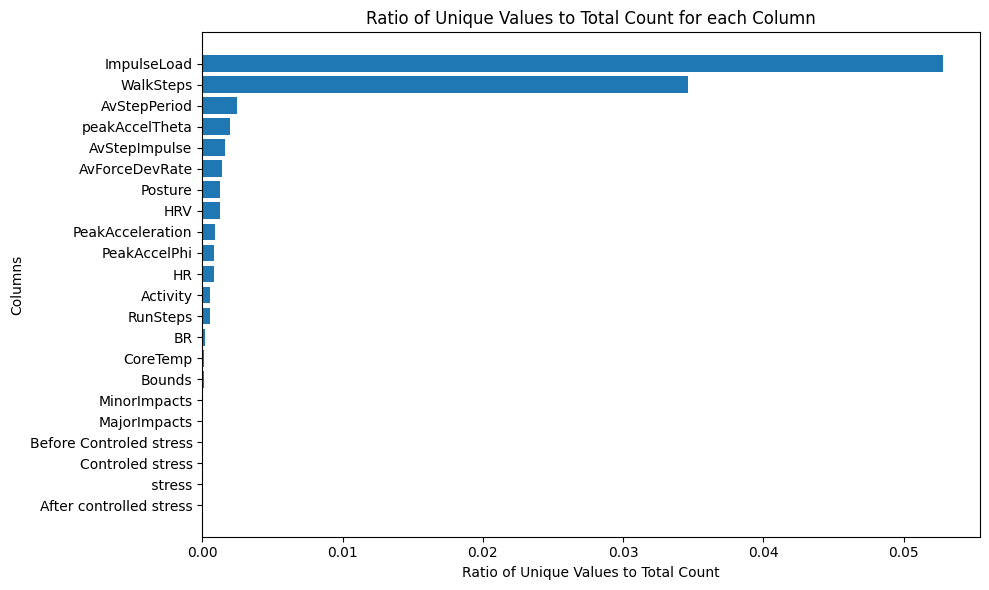

In [10]:
ratios = (X_preprocessed.nunique() / X_preprocessed.count()).sort_values(ascending=True)

# Create a bar plot to visualize the ratios
plt.figure(figsize=(10, 6))
plt.barh(ratios.index, ratios.values)
plt.xlabel('Ratio of Unique Values to Total Count')
plt.ylabel('Columns')
plt.title('Ratio of Unique Values to Total Count for each Column')
plt.tight_layout()
plt.show()

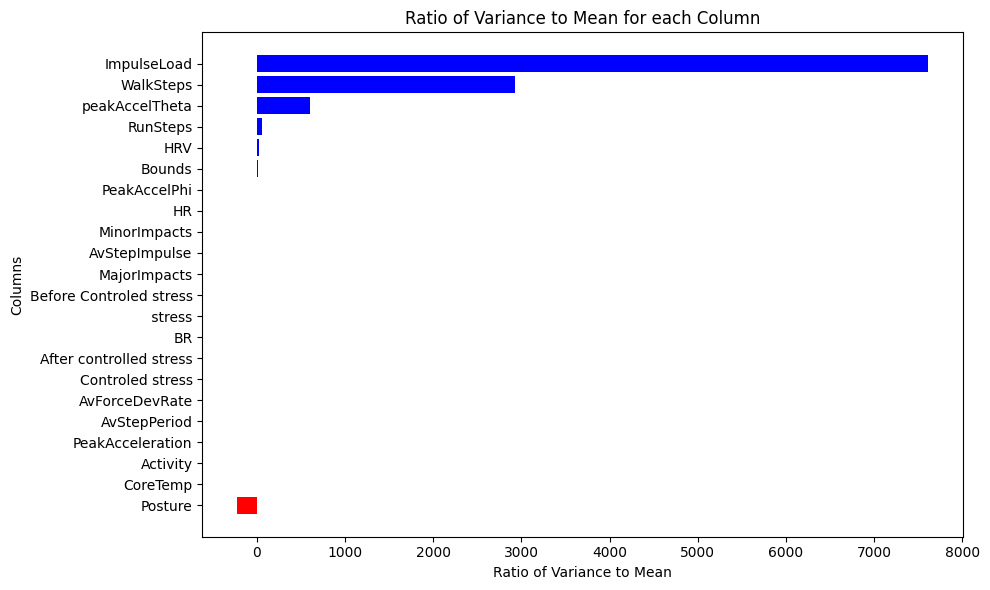

In [11]:
import matplotlib.pyplot as plt

# Assuming you have already calculated the ratio of variance to mean
ratios = (X_preprocessed.var() / X_preprocessed.mean()).sort_values(ascending=True)

# Create a bar plot to visualize the ratios
plt.figure(figsize=(10, 6))

# Color negative values in red, and non-negative values in the default color (blue)
colors = ['red' if value < 0 else 'blue' for value in ratios.values]

plt.barh(ratios.index, ratios.values, color=colors)
plt.xlabel('Ratio of Variance to Mean')
plt.ylabel('Columns')
plt.title('Ratio of Variance to Mean for each Column')
plt.tight_layout()
plt.show()


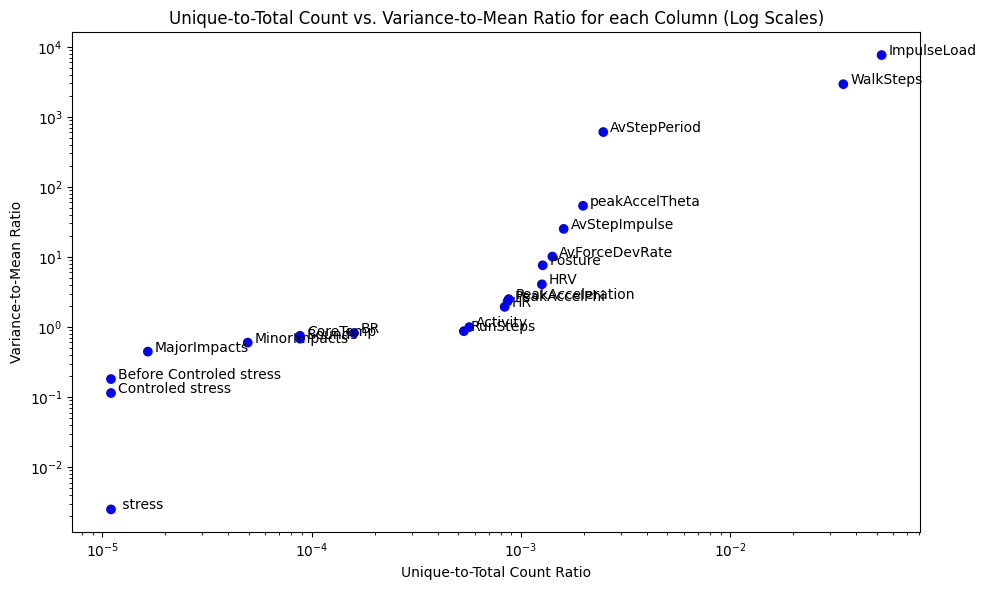

In [12]:
import matplotlib.pyplot as plt

# Assuming you have already calculated the ratio of unique values to total count and variance to mean
unique_ratios = (X_preprocessed.nunique() / X_preprocessed.count()).sort_values(ascending=True)
variance_ratios = (X_preprocessed.var() / X_preprocessed.mean()).sort_values(ascending=True)

# Create a scatter plot to combine the two ratios
plt.figure(figsize=(10, 6))


# Plot the scatter plot with unique-to-total count ratios on the x-axis and variance-to-mean ratios on the y-axis
plt.scatter(unique_ratios.values, variance_ratios.values, color=colors)

# Annotate each point with the column name next to the data point
for i, col in enumerate(unique_ratios.index):
    plt.annotate(col, xy=(unique_ratios.values[i], variance_ratios.values[i]),
                 xytext=(5, 0), textcoords='offset points')

# Set log scales for both x and y axes
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Unique-to-Total Count Ratio')
plt.ylabel('Variance-to-Mean Ratio')
plt.title('Unique-to-Total Count vs. Variance-to-Mean Ratio for each Column (Log Scales)')
plt.tight_layout()

plt.show()


## Non Zero transformer

In [13]:
class AnyGreaterThanZeroTransformer:
    def __init__(self, columns, c_name):
        
        self.columns = columns
        self.c_name = c_name
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Concatenate the names of the specified columns into a new column
        X[f'{self.c_name}'] =   (X[self.columns] > 0).any(axis=1).astype(int)

        # Drop the original specified columns as they are no longer needed
        X.drop(columns=self.columns, inplace=True)

        return X

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [14]:
X_non_binary = X_preprocessed.copy()

### Stress

<Figure size 1000x600 with 0 Axes>

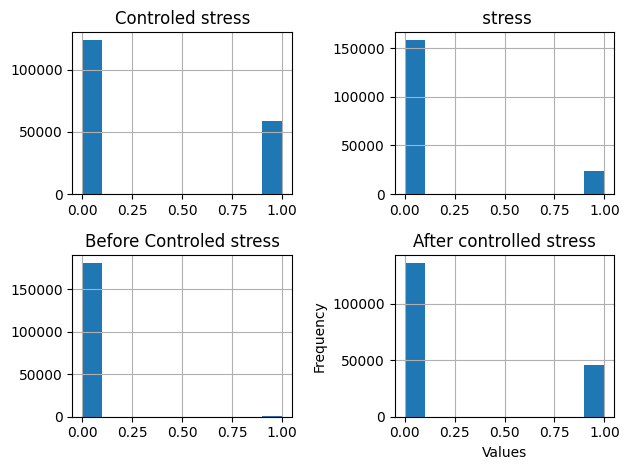

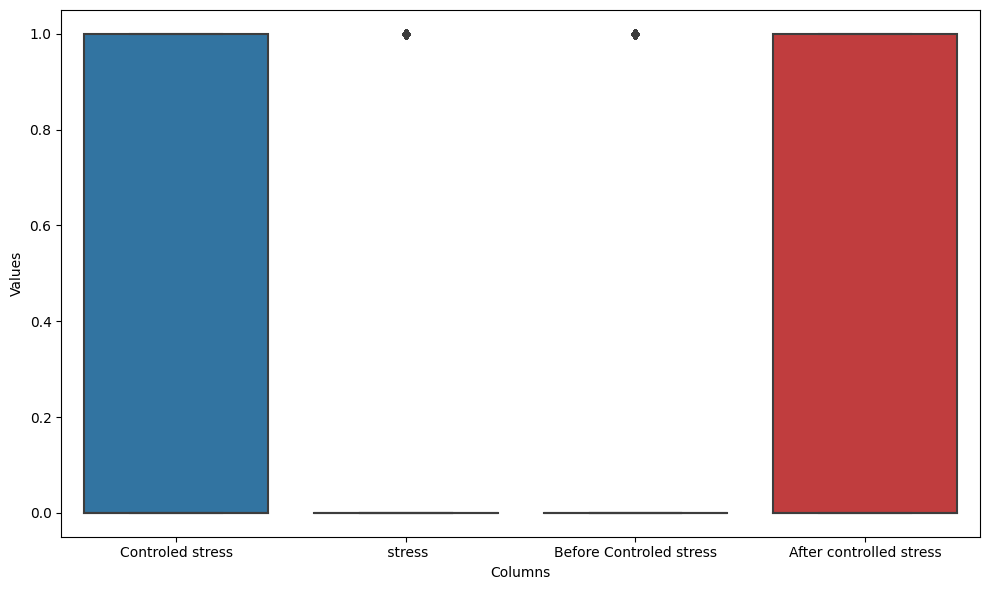

In [15]:
# Plot histograms for the specified columns
plt.figure(figsize=(10, 6))
X_preprocessed.hist(column=['Controled stress', ' stress', 'Before Controled stress', 'After controlled stress'], bins=10)
plt.xlabel('Values')
plt.ylabel('Frequency')
# plt.title('Histograms for the Specified Columns')
plt.tight_layout()
plt.show()

# Plot boxplots for the specified columns
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_preprocessed[['Controled stress', ' stress', 'Before Controled stress', 'After controlled stress']])
plt.xlabel('Columns')
plt.ylabel('Values')
# plt.title('Boxplots for the Specified Columns')
plt.tight_layout()
plt.show()

In [16]:
# Use the fit_transform method to create the new column 'AnyGreaterThanZero'
Stress_Data = X_non_binary.copy()
Stress_Data = AnyGreaterThanZeroTransformer(columns=['Controled stress',' stress', 'Before Controled stress', 'After controlled stress'],
                                            c_name = 'Stress_Binary')\
                                            .fit_transform(X_non_binary)

### Impact

<Figure size 1000x600 with 0 Axes>

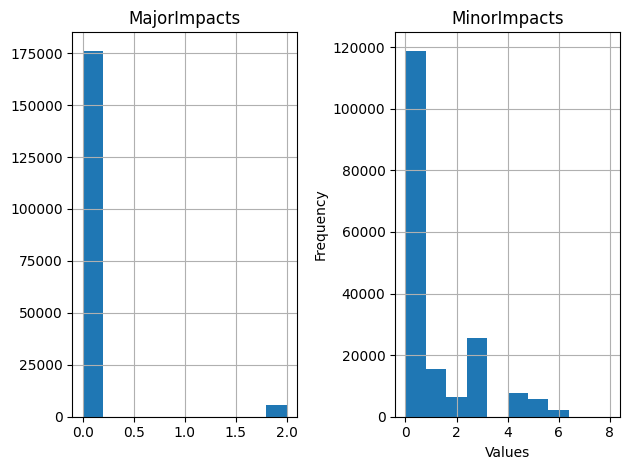

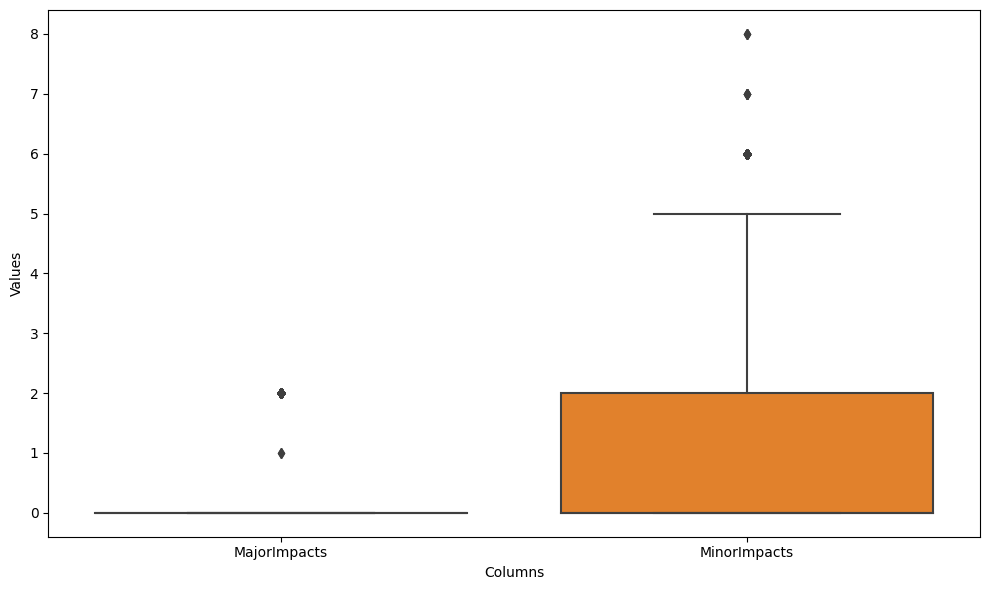

In [17]:
# Plot histograms for the specified columns
plt.figure(figsize=(10, 6))
X_preprocessed.hist(column=['MajorImpacts','MinorImpacts'], bins=10)
plt.xlabel('Values')
plt.ylabel('Frequency')
# plt.title('Histograms for the Specified Columns')
plt.tight_layout()
plt.show()

# Plot boxplots for the specified columns
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_preprocessed[['MajorImpacts','MinorImpacts']])
plt.xlabel('Columns')
plt.ylabel('Values')
# plt.title('Boxplots for the Specified Columns')
plt.tight_layout()
plt.show()

In [18]:
Impact_Data = AnyGreaterThanZeroTransformer(columns=['MajorImpacts','MinorImpacts']
                                           ,c_name = 'Impact_Binary')\
                                            .fit_transform(Stress_Data)

### Av* Data

<Figure size 1000x600 with 0 Axes>

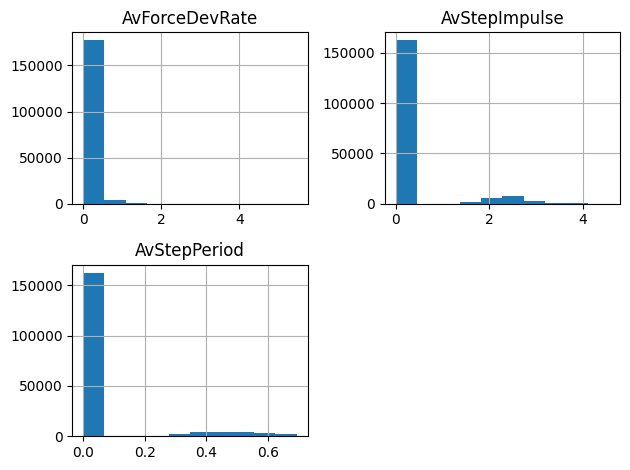

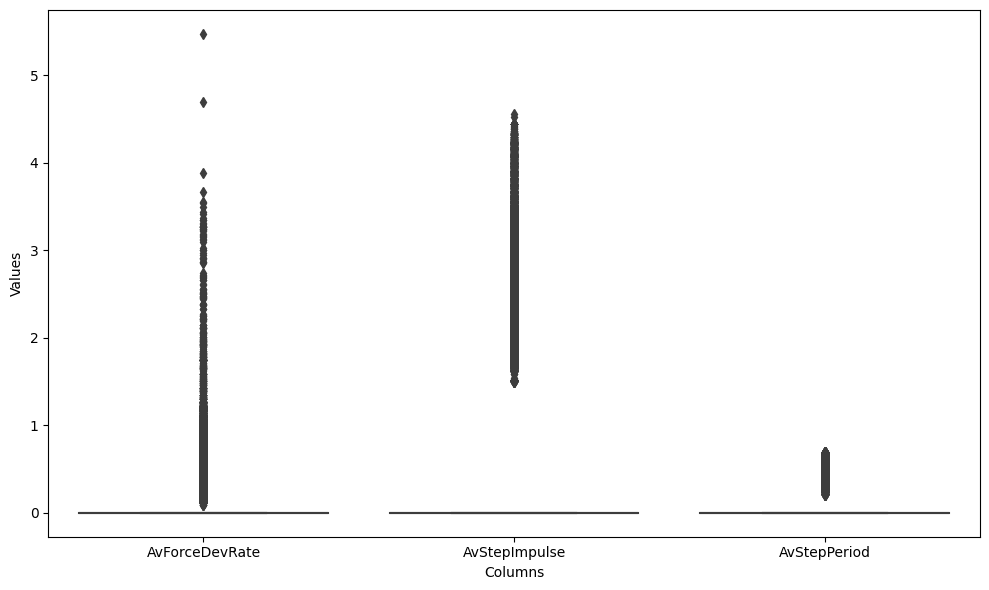

In [19]:
# Plot histograms for the specified columns
plt.figure(figsize=(10, 6))
X_preprocessed.hist(column=['AvForceDevRate', 'AvStepImpulse', 'AvStepPeriod'], bins=10)
plt.xlabel('Values')
plt.ylabel('Frequency')
# plt.title('Histograms for the Specified Columns')
plt.tight_layout()
plt.show()

# Plot boxplots for the specified columns
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_preprocessed[['AvForceDevRate', 'AvStepImpulse', 'AvStepPeriod']])
plt.xlabel('Columns')
plt.ylabel('Values')
# plt.title('Boxplots for the Specified Columns')
plt.tight_layout()
plt.show()

In [20]:
Av_Data = AnyGreaterThanZeroTransformer(columns=['AvForceDevRate', 'AvStepImpulse', 'AvStepPeriod']
                                           ,c_name = 'Av_Binary')\
                                            .fit_transform(Stress_Data)

### Peak Data

<Figure size 1000x600 with 0 Axes>

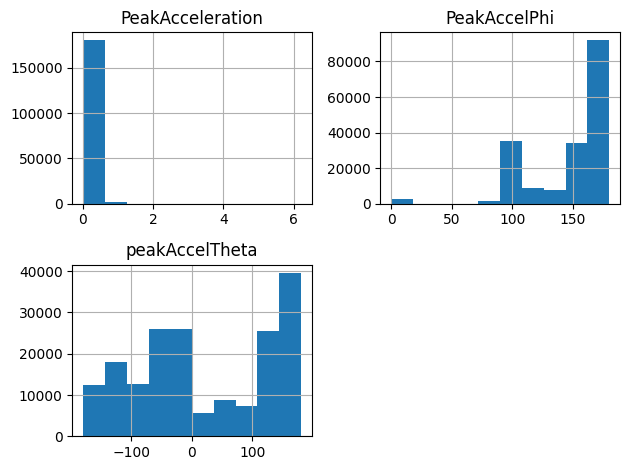

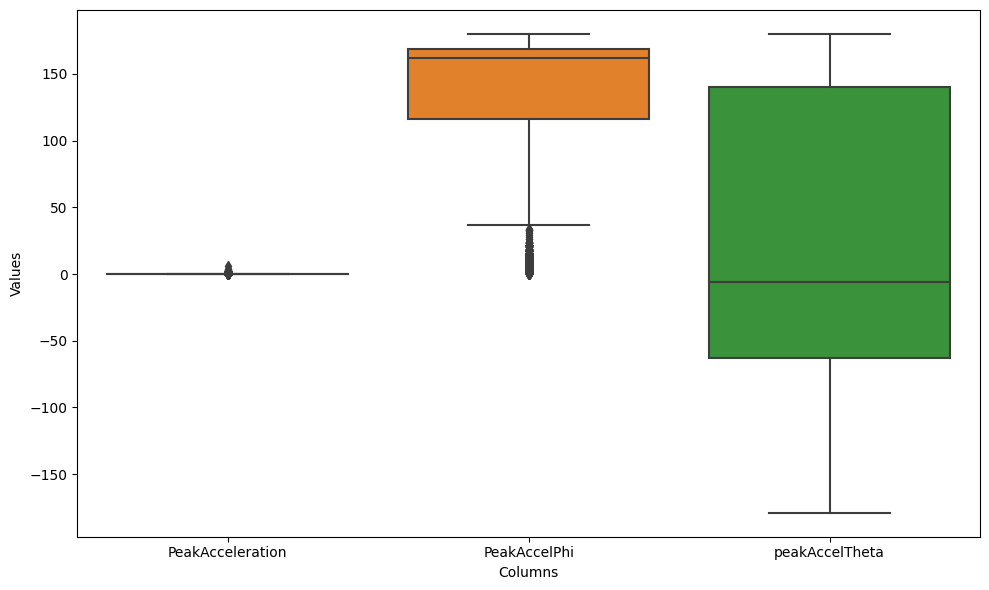

In [21]:
# Plot histograms for the specified columns
plt.figure(figsize=(10, 6))
X_preprocessed.hist(column=['PeakAcceleration', 'PeakAccelPhi', 'peakAccelTheta'], bins=10)
plt.xlabel('Values')
plt.ylabel('Frequency')
# plt.title('Histograms for the Specified Columns')
plt.tight_layout()
plt.show()

# Plot boxplots for the specified columns
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_preprocessed[['PeakAcceleration', 'PeakAccelPhi', 'peakAccelTheta']])
plt.xlabel('Columns')
plt.ylabel('Values')
# plt.title('Boxplots for the Specified Columns')
plt.tight_layout()
plt.show()

In [22]:
Accel_Data = AnyGreaterThanZeroTransformer(columns=['PeakAcceleration']
                                           ,c_name = 'Acc_Binary')\
                                            .fit_transform(Stress_Data)

### Bounds

<Figure size 1000x600 with 0 Axes>

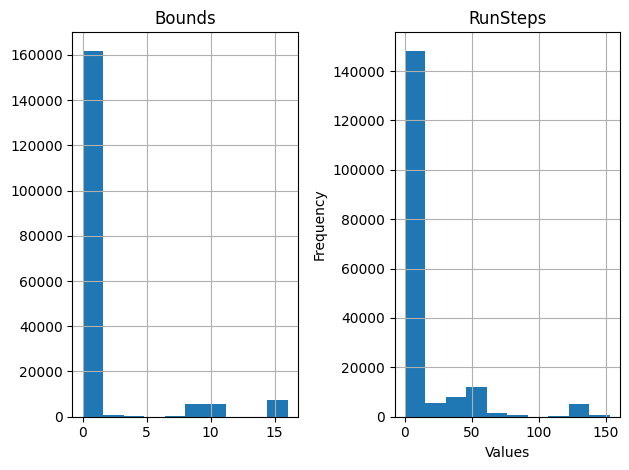

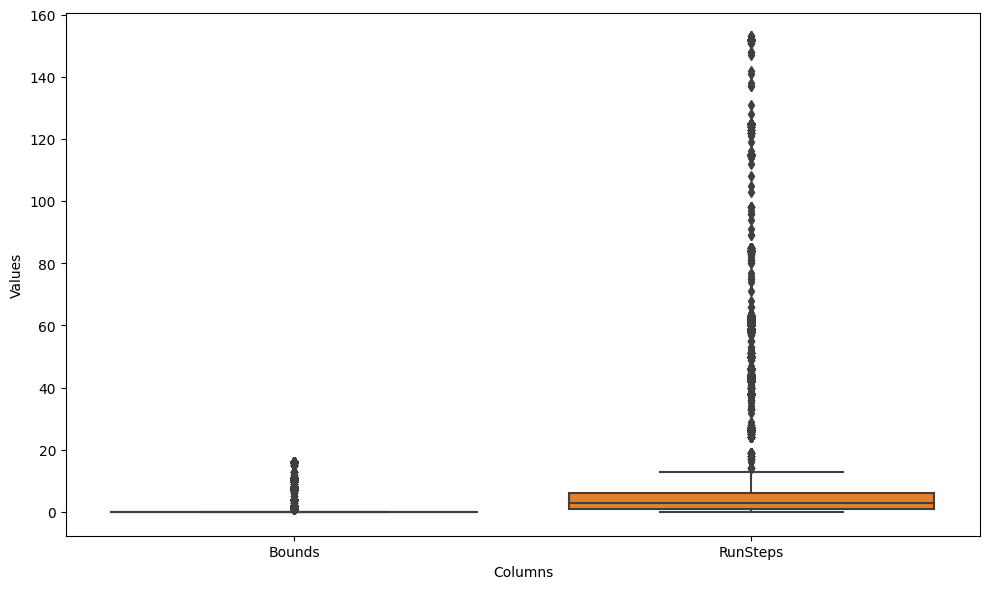

In [23]:
# Plot histograms for the specified columns
plt.figure(figsize=(10, 6))
X_preprocessed.hist(column=['Bounds', 'RunSteps'], bins=10)
plt.xlabel('Values')
plt.ylabel('Frequency')
# plt.title('Histograms for the Specified Columns')
plt.tight_layout()
plt.show()

# Plot boxplots for the specified columns
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_preprocessed[['Bounds', 'RunSteps']])
plt.xlabel('Columns')
plt.ylabel('Values')
# plt.title('Boxplots for the Specified Columns')
plt.tight_layout()
plt.show()

In [24]:
Bounds_Data = AnyGreaterThanZeroTransformer(columns=['Bounds']
                                           ,c_name = 'Bounds_Binary')\
                                            .fit_transform(Stress_Data)

## Data Cleaning

In [25]:
X_train_outlier = Bounds_Data.copy()

In [26]:
# Identify non-binary columns
non_binary_columns = X_train_outlier.columns[X_train_outlier.nunique() > 2]
binary_clumns = X_train_outlier.drop(columns = non_binary_columns).columns.tolist()

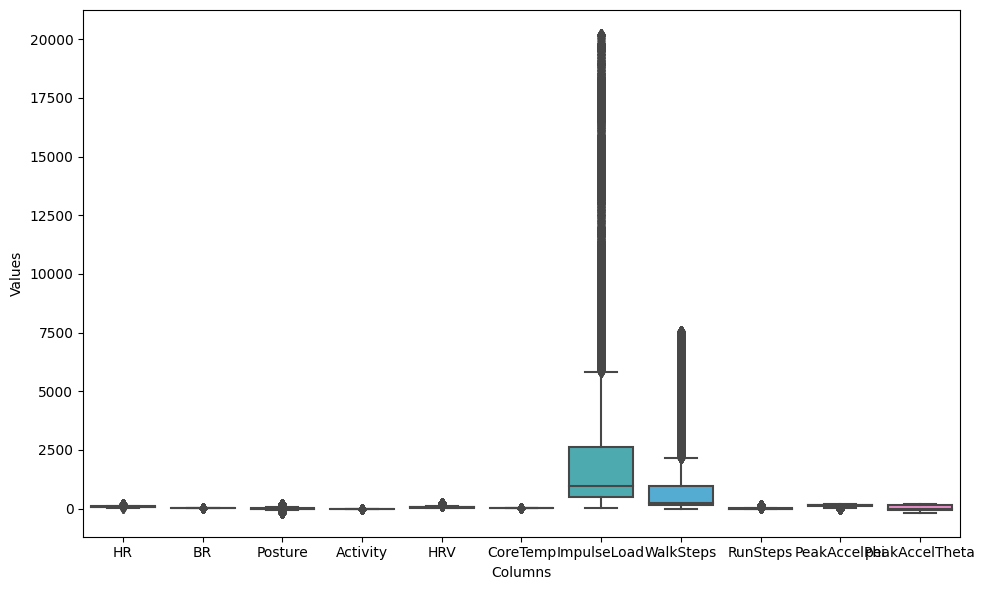

In [27]:
# Plot boxplots for the specified columns
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train_outlier[non_binary_columns])
plt.xlabel('Columns')
plt.ylabel('Values')
# plt.title('Boxplots for the Specified Columns')
plt.tight_layout()
plt.show()

### Outlier Replacer

In [28]:
class OutlierReplacer:
    def __init__(self, columns):
        self.columns = columns
        self.iqr_ranges = {}

    def fit(self, X, y=None):
        for column in self.columns:
            Q1 = X[column].quantile(0.25)
            Q3 = X[column].quantile(0.75)
            IQR = Q3 - Q1
            self.iqr_ranges[column] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

        return self

    def transform(self, X):
        X_transformed = X.copy()

        for column in self.columns:
            if column in self.iqr_ranges:
                outliers = (X_transformed[column] < self.iqr_ranges[column][0]) | (X_transformed[column] > self.iqr_ranges[column][1])
                detected_outliers = X_transformed[outliers]

                clean_data_iqr = X_transformed[~outliers].fillna(0)

                mean_value = clean_data_iqr[column].mean()
                noise = np.random.normal(0, 0.1, len(detected_outliers))
                mean_value_with_noise = noise + mean_value

                X_transformed.loc[outliers, column] = mean_value_with_noise

        return X_transformed

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [29]:
# Instantiate the OutlierReplacer class and fit_transform on training data
outlier_replacer = OutlierReplacer(columns=non_binary_columns).fit(X_train_outlier)

X_train_less_outliers = outlier_replacer.transform(X_train_outlier)


## Scaler

In [30]:
scaler = StandardScaler().fit(X_train_less_outliers)

In [31]:
# Make a copy of the original DataFrame
X_train_scaled = X_train_less_outliers.copy()

# Instantiate the StandardScaler with the selected columns and fit and transform them
scaler = StandardScaler().fit(X_train_less_outliers[non_binary_columns])

X_train_scaled[non_binary_columns] = scaler.transform(X_train_less_outliers[non_binary_columns])


## Label Encoder

In [32]:
label_encoder = LabelEncoder().fit(y_train)

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [33]:
y_train['Target'] = label_encoder.transform(y_train)

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [34]:
y_train_target = y_train[['Target']]

# Model

In [35]:
clf1 = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

clf2 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42
)

clf3 = AdaBoostClassifier(
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)

clf4 = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    random_state=42
)


clf5 = DecisionTreeClassifier(
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Define the ensemble classifier with the scaler
models = VotingClassifier(estimators=[
    ('rfc', clf1), 
    ('xgb', clf2), 
    ('ada', clf3), 
    ('gbc', clf4), 
    ('dtc', clf5)],
    voting='soft')

# Fit the pipeline to the training data
models.fit(X_train_scaled, y_train_target)


C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


VotingClassifier(estimators=[('rfc', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_typ...
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...)),
                             ('ada', AdaBoostClassifier(random_state=42)),
                             ('gbc',
                              GradientBoostingClassifier(random_state=42)),
                             ('dtc', DecisionTreeClassifier(random_state=42))],
                 voting='soft')

In [36]:
y_pred_train = models.predict(X_train_scaled)

In [37]:
# Generate a classification report
class_report = classification_report(y_pred_train, y_train_target)

In [38]:
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00      2055
           3       1.00      1.00      1.00      2511
           4       1.00      1.00      1.00      3301
           5       1.00      1.00      1.00     44443
           6       1.00      1.00      1.00      1270
           7       1.00      1.00      1.00      1758
           8       1.00      1.00      1.00      5100
           9       1.00      1.00      1.00     48613
          10       1.00      1.00      1.00      2783
          11       1.00      1.00      1.00      2188
          12       1.00      1.00      1.00      2227
          13       1.00      1.00      1.00      7151
          14       1.00      1.00      1.00      2216
          15       1.00      1.00      1.00      5651
          16       1.00      1.00      1.00     46898
    

## Save model

In [39]:
# Save the pipeline to a file
filename = 'ensamble_fitted_model_summerschool2023_stress.joblib'
joblib.dump(models, filename)

['ensamble_fitted_model_summerschool2023_stress.joblib']

## Feature Importance

In [40]:
# Get feature importances for each individual model
feature_importances = pd.DataFrame()

for name, clf in models.named_estimators_.items():
    if hasattr(clf, 'feature_importances_'):
        feature_importances[name] = clf.feature_importances_

feature_importances.index = X_train_scaled.columns

In [41]:
feature_importances

,rfc,xgb,ada,gbc,dtc
HR,0.032565,0.008721,0.00,0.001007,0.001007
BR,0.010093,0.008453,0.00,0.001348,0.000759
Posture,0.044432,0.027156,0.00,0.029571,0.016434
Activity,0.001211,0.000171,0.00,0.000027,0.000149
HRV,0.059238,0.023727,0.00,0.043664,0.050683
CoreTemp,0.098343,0.035278,0.00,0.033735,0.037238
ImpulseLoad,0.092955,0.032310,0.00,0.049537,0.093107
WalkSteps,0.121681,0.029769,0.00,0.084308,0.092966
RunSteps,0.125394,0.061232,0.66,0.154978,0.195269
PeakAccelPhi,0.117507,0.374805,0.00,0.228133,0.218843


<Axes: >

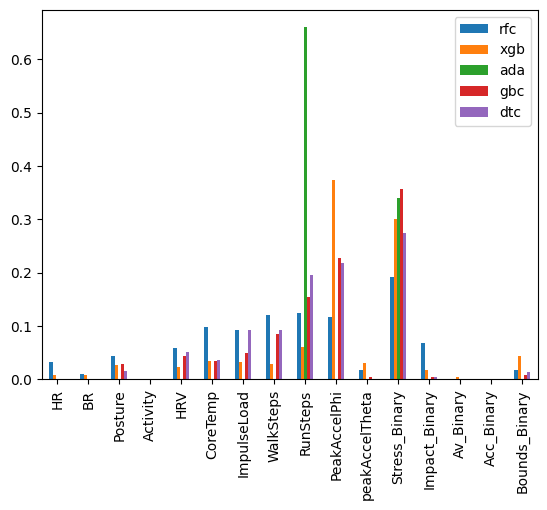

In [42]:
feature_importances.plot(kind='bar')

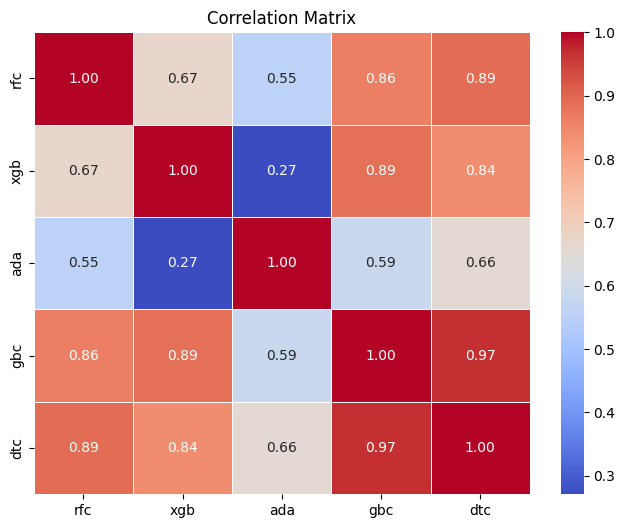

In [43]:
# Calculate the correlation matrix
corr_matrix = feature_importances.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## X_test & Y_test prep

In [44]:
X_test_initial = X_test.copy()
X_test_loaded = data_cleaner.transform(X_test_initial)   #data cleaning
X_test_preprocessed = X_test_loaded.drop(columns = drop) #columns drop
X_test_non_binary = X_test_preprocessed.copy()           #copy df

In [45]:
X_test_Stress_Data = X_test_non_binary.copy()
X_test_Stress_Data = AnyGreaterThanZeroTransformer(columns=['Controled stress',' stress', 'Before Controled stress', 'After controlled stress'],
                                            c_name = 'Stress_Binary')\
                                            .transform(X_test_non_binary)  #binary stress



X_test_Impact_Data = AnyGreaterThanZeroTransformer(columns=['MajorImpacts','MinorImpacts']
                                           ,c_name = 'Impact_Binary')\
                                            .transform(X_test_Stress_Data) #binary impacts

X_test_Av_Data = AnyGreaterThanZeroTransformer(columns=['AvForceDevRate', 'AvStepImpulse', 'AvStepPeriod']
                                           ,c_name = 'Av_Binary')\
                                            .transform(X_test_Impact_Data) #binary av columns 

X_test_Accel_Data = AnyGreaterThanZeroTransformer(columns=['PeakAcceleration']
                                           ,c_name = 'Acc_Binary')\
                                            .transform(X_test_Impact_Data) #binary accel

X_test_Bounds_Data = AnyGreaterThanZeroTransformer(columns=['Bounds']
                                           ,c_name = 'Bounds_Binary')\
                                            .transform(X_test_Accel_Data)  #binary bounds

In [46]:
X_test_outlier = X_test_Bounds_Data.copy()                                              #copying the data before outlier removal
X_test_less_outliers = outlier_replacer.transform(X_test_outlier)                       #outliers removal
X_test_scaled = X_test_less_outliers.copy()                                             #outliers df copy
X_test_scaled[non_binary_columns] = scaler.transform(X_test_scaled[non_binary_columns]) # replace the og df

In [47]:
y_test['Target'] = label_encoder.transform(y_test) #transforming labels
y_test_target = y_test[['Target']]                 #predictor class

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


# Model Loading

In [48]:
loaded_model = joblib.load('ensamble_fitted_model_summerschool2023_stress.joblib') 

In [49]:
loaded_model

VotingClassifier(estimators=[('rfc', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_typ...
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...)),
                             ('ada', AdaBoostClassifier(random_state=42)),
                             ('gbc',
                              GradientBoostingClassifier(random_state=42)),
                             ('dtc', DecisionTreeClassifier(random_state=42))],
                 voting='soft')

In [50]:
y_test_pred = loaded_model.predict(X_test_scaled)

In [51]:
# Generate a classification report
test_class_report = classification_report(y_test_pred,y_test_target )

In [52]:
print("Classification Report:")
print(test_class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00       211
           2       1.00      1.00      1.00      1012
           3       1.00      1.00      1.00      1239
           4       1.00      1.00      1.00      1626
           5       1.00      1.00      1.00     21890
           6       1.00      1.00      1.00       625
           7       1.00      1.00      1.00       866
           8       1.00      1.00      1.00      2508
           9       1.00      1.00      1.00     23950
          10       1.00      1.00      1.00      1371
          11       1.00      1.00      1.00      1077
          12       1.00      1.00      1.00      1098
          13       1.00      1.00      1.00      3522
          14       1.00      1.00      1.00      1090
          15       1.00      1.00      1.00      2782
          16       1.00      1.00      1.00     23104
    